In [1]:
import numpy as np
import pandas as pd
import yaml
import sys
import os
import pickle
from glob import glob
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering_det.stage1 import generate_1st_stage_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["1st_stage_det"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['1st_stage_det']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-02 07:01:00.168521: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 07:01:00.569036: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-02 07:01:01.702013: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_055
rm: cannot remove '/kaggle/output/exp_055': No such file or directory


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_det_csv_dir']}/*.csv")
train, features = generate_1st_stage_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
print(train.shape)

generate features: 100%|██████████| 277/277 [06:44<00:00,  1.46s/it]


,anglez_diff_abs,anglez_diff_abs_rolling_max_10,anglez_diff_abs_rolling_max_100,anglez_diff_abs_rolling_max_1000,anglez_diff_abs_rolling_max_50,anglez_diff_abs_rolling_mean_10,anglez_diff_abs_rolling_mean_100,anglez_diff_abs_rolling_mean_1000,anglez_diff_abs_rolling_mean_50,anglez_diff_abs_rolling_median_10,...,enmo_rolling_std_10,enmo_rolling_std_100,enmo_rolling_std_1000,enmo_rolling_std_50,total_seconds,target_wakeup,target_onset,step,series_id,fold
0,0.006461,0.043200,NaN,NaN,NaN,0.007771,NaN,NaN,NaN,0.000428,...,0.000000,NaN,NaN,NaN,40557.5,0,0,11.5,af91d9a50547,3
1,0.000117,0.000833,NaN,NaN,0.047400,0.000192,NaN,NaN,0.002144,0.000004,...,0.000000,NaN,NaN,0.000000,40677.5,0,0,35.5,af91d9a50547,3
2,0.000767,0.005475,0.5969,NaN,0.457854,0.001198,0.022684,NaN,0.024919,0.000319,...,0.000000,0.00146,NaN,0.001634,40797.5,0,0,59.5,af91d9a50547,3
3,0.083833,0.347392,0.5969,NaN,0.596900,0.083032,0.025412,NaN,0.042692,0.036481,...,0.001924,0.00146,NaN,0.002064,40917.5,0,0,83.5,af91d9a50547,3
4,0.014787,0.048846,0.5969,NaN,0.309038,0.012615,0.028460,NaN,0.028898,0.001910,...,0.000000,0.00146,NaN,0.000604,41037.5,0,0,107.5,af91d9a50547,3


(5331163, 204)


In [3]:
# 学習
for c in ["wakeup", "onset"]:
    trn_oof, models = fit_xgb(
        X=train, 
        y=train[f"target_{c}"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG["1st_stage_det"]["xgboost"], 
        es_rounds=100,
    )
    train[f"oof_{c}"] = trn_oof

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}_{c}.model'))
        
with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train = train.drop(columns=features.all_features())
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:0.89129
[100]	eval-rmse:0.57897
[200]	eval-rmse:0.57462
[300]	eval-rmse:0.57308
[400]	eval-rmse:0.57217
[500]	eval-rmse:0.57085
[600]	eval-rmse:0.57056
[648]	eval-rmse:0.57052


 20%|██        | 1/5 [00:54<03:37, 54.29s/it]

== fold 1 ==
[0]	eval-rmse:0.84238
[100]	eval-rmse:0.56957
[200]	eval-rmse:0.56729
[300]	eval-rmse:0.56571
[400]	eval-rmse:0.56470
[500]	eval-rmse:0.56512
[506]	eval-rmse:0.56518


 40%|████      | 2/5 [01:35<02:20, 46.71s/it]

== fold 2 ==
[0]	eval-rmse:0.88668
[100]	eval-rmse:0.58360
[200]	eval-rmse:0.57939
[300]	eval-rmse:0.57778
[400]	eval-rmse:0.57679
[500]	eval-rmse:0.57607
[600]	eval-rmse:0.57589
[691]	eval-rmse:0.57598


 60%|██████    | 3/5 [02:27<01:37, 48.82s/it]

== fold 3 ==
[0]	eval-rmse:0.87555
[100]	eval-rmse:0.58170
[200]	eval-rmse:0.57760
[300]	eval-rmse:0.57645
[400]	eval-rmse:0.57672
[474]	eval-rmse:0.57865


 80%|████████  | 4/5 [03:05<00:44, 44.79s/it]

== fold 4 ==
[0]	eval-rmse:0.89212
[100]	eval-rmse:0.58929
[200]	eval-rmse:0.58386
[300]	eval-rmse:0.58179
[400]	eval-rmse:0.58010
[500]	eval-rmse:0.57944
[600]	eval-rmse:0.57861
[700]	eval-rmse:0.57817
[800]	eval-rmse:0.57822
[809]	eval-rmse:0.57820


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:0.89505
[100]	eval-rmse:0.62351
[200]	eval-rmse:0.61825
[300]	eval-rmse:0.61633
[400]	eval-rmse:0.61535
[500]	eval-rmse:0.61464
[600]	eval-rmse:0.61517
[648]	eval-rmse:0.61505


 20%|██        | 1/5 [00:49<03:19, 49.77s/it]

== fold 1 ==
[0]	eval-rmse:0.84583
[100]	eval-rmse:0.58089
[200]	eval-rmse:0.57517
[300]	eval-rmse:0.57272
[400]	eval-rmse:0.57140
[500]	eval-rmse:0.57112
[595]	eval-rmse:0.57132


 40%|████      | 2/5 [01:35<02:21, 47.29s/it]

== fold 2 ==
[0]	eval-rmse:0.88982
[100]	eval-rmse:0.63399
[200]	eval-rmse:0.62903
[300]	eval-rmse:0.62696
[400]	eval-rmse:0.62642
[500]	eval-rmse:0.62629
[600]	eval-rmse:0.62600
[632]	eval-rmse:0.62587


 60%|██████    | 3/5 [02:22<01:34, 47.43s/it]

== fold 3 ==
[0]	eval-rmse:0.88097
[100]	eval-rmse:0.63531
[200]	eval-rmse:0.62943
[300]	eval-rmse:0.62797
[400]	eval-rmse:0.62682
[500]	eval-rmse:0.62664
[537]	eval-rmse:0.62677


 80%|████████  | 4/5 [03:04<00:45, 45.07s/it]

== fold 4 ==
[0]	eval-rmse:0.89800
[100]	eval-rmse:0.64336
[200]	eval-rmse:0.63785
[300]	eval-rmse:0.63571
[400]	eval-rmse:0.63472
[500]	eval-rmse:0.63509
[520]	eval-rmse:0.63521


100%|██████████| 5/5 [03:44<00:00, 44.85s/it]


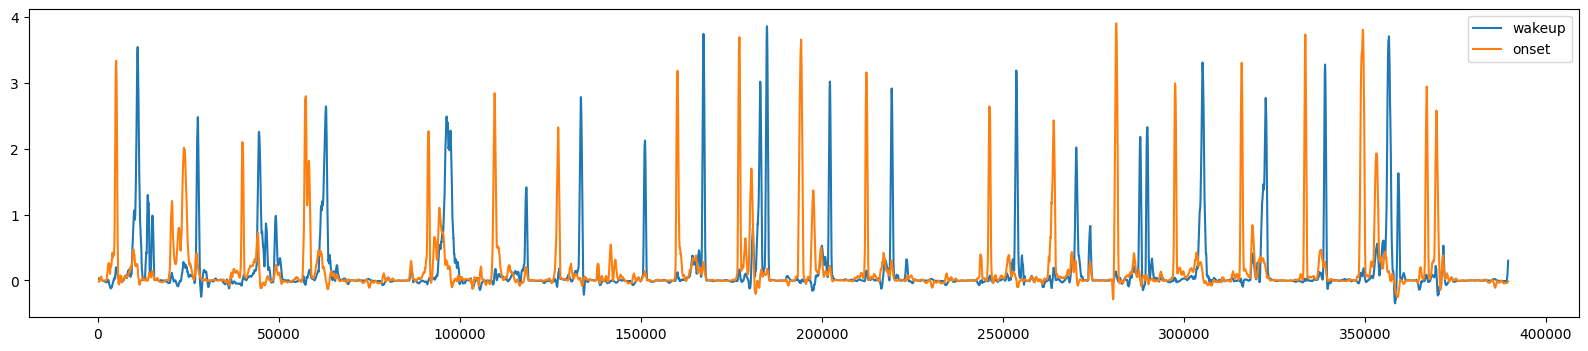

In [10]:
import matplotlib.pyplot as plt

for series_id, df in train.groupby("series_id"):
    plt.subplots(figsize=(20, 4))
    df["rolled_oof_wakeup"] = df["oof_wakeup"].rolling(24, center=True).mean().fillna(0)
    df["rolled_oof_onset"] = df["oof_onset"].rolling(24, center=True).mean().fillna(0)
    plt.plot(df["step"], df["rolled_oof_wakeup"], label="wakeup")
    plt.plot(df["step"], df["rolled_oof_onset"], label="onset")

    # イベントの時刻
    wakeup_index = np.array([i for i in range(1, len(df["oof"])) if df["oof"][i - 1] < 0.5 and df["oof"][i] >= 0.5])
    onset_index = np.array([i for i in range(1, len(df["oof"])) if df["oof"][i - 1] > 0.5 and df["oof"][i] <= 0.5])


    plt.legend()
    plt.show()
    break

In [4]:
# 後処理
sub = post_process(train)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)

post process: 100%|██████████| 277/277 [00:46<00:00,  5.98it/s]


score: 0.5143


event   tolerance
onset   12           0.007410
        36           0.063323
        60           0.180587
        90           0.356458
        120          0.539562
        150          0.616559
        180          0.676332
        240          0.729481
        300          0.763573
        360          0.778655
wakeup  12           0.025611
        36           0.183351
        60           0.365586
        90           0.530580
        120          0.618199
        150          0.685890
        180          0.730202
        240          0.787793
        300          0.813421
        360          0.832656
dtype: float64

In [5]:
# 次の候補を決定
next_cand_size = 0
count = 0
next_dict = {}
for series_id, train_df in train.groupby("series_id"):
    train_df = train_df[(train_df["oof"] >= 0.1) & (train_df["oof"] <= 0.9)]
    sub_df = sub[(sub["series_id"] == series_id)]
    label_df = labels[labels["series_id"] == series_id]
    pred_steps = train_df["step"].values
    sub_steps = sub_df["step"].values
    label_steps = label_df["step"].values

    if len(train_df) == 0:
        continue
    next_cand = np.zeros(int(max(max(pred_steps if len(pred_steps) > 0 else [0]), max(sub_steps if len(sub_steps) > 0 else [0]))) + CFG["feature"]["agg_freq"])
    for sub_step in sub_steps:
        next_cand[int(sub_step - CFG["feature"]["agg_freq"] * 10): int(sub_step + CFG["feature"]["agg_freq"] * 10)] = 1
    for pred_step in pred_steps:
        next_cand[int(pred_step - CFG["feature"]["agg_freq"] * 10): int(pred_step + CFG["feature"]["agg_freq"] * 10)] = 1
    next_cand_size += np.sum(next_cand)
    next_dict[series_id] = np.where(next_cand)[0]

    for label_step in label_steps:
        if label_step < next_cand.shape[0]:
            count += next_cand[int(label_step)]
    
recall = count / len(labels)
print(f"recall: {recall:.4f}")
print(f"next_cand_size: {next_cand_size}")

with open(f"{CFG['output_dir']}/next_cands.pkl", "wb") as f:
    pickle.dump(next_dict, f)

recall: 0.9729
next_cand_size: 21062664.0
